In [1]:
# 필수 라이브러리
import os
import time
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "../12th_project/Dirty/"
batch_size = 32
num_classes = 6
epochs = 15
lr = 1e-4
patience = 5

In [ ]:
# 데이터 전처리 및 로딩
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
# 데이터셋 불러오기
dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# 학습/검증/테스트 분할 (80:10:10)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# 모델 정의
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [6]:
# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [7]:
print("✔ CUDA 사용 가능:", torch.cuda.is_available())
print("✔ 전체 데이터 수:", len(dataset))
print("✔ 클래스 목록:", dataset.classes)
print("✔ 배치 수 (train):", len(train_loader))

✔ CUDA 사용 가능: False
✔ 전체 데이터 수: 2527
✔ 클래스 목록: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
✔ 배치 수 (train): 64


In [33]:
# 학습 함수 + 조기종료
def train_model():
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        # 학습 단계
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total * 100

        # 검증 단계 + 정확도 계산 추가됨
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, val_predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (val_predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total * 100

        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        # 조기 종료 체크
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), "best_model.pt")  # 최적 모델 저장
        else:
            counter += 1
            if counter >= patience:
                print("조기 종료 triggered.")
                break

# 평가 함수
def evaluate_model():
    model.load_state_dict(torch.load("best_model.pt"))  # 최적 모델 불러오기
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n테스트 정확도: {acc * 100:.2f}%")

    print("\n성능 평가표:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # 혼동 행렬 시각화 추가
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset.classes,
                yticklabels=dataset.classes)
    plt.title("혼동 행렬 (Test Set)")
    plt.xlabel("예측 클래스")
    plt.ylabel("실제 클래스")
    plt.tight_layout()
    plt.show()



학습 시작
[Epoch 1] Train Loss: 1.0748, Val Loss: 0.4014, Train Acc: 65.86%, Val Acc: 86.90%
[Epoch 2] Train Loss: 0.2827, Val Loss: 0.2220, Train Acc: 92.33%, Val Acc: 92.86%
[Epoch 3] Train Loss: 0.0968, Val Loss: 0.1481, Train Acc: 97.92%, Val Acc: 94.44%
[Epoch 4] Train Loss: 0.0707, Val Loss: 0.1489, Train Acc: 97.77%, Val Acc: 93.65%
[Epoch 5] Train Loss: 0.0475, Val Loss: 0.1490, Train Acc: 98.91%, Val Acc: 95.24%
[Epoch 6] Train Loss: 0.0210, Val Loss: 0.1392, Train Acc: 99.60%, Val Acc: 94.44%
[Epoch 7] Train Loss: 0.0357, Val Loss: 0.1530, Train Acc: 98.91%, Val Acc: 94.44%
[Epoch 8] Train Loss: 0.0225, Val Loss: 0.1252, Train Acc: 99.46%, Val Acc: 95.24%
[Epoch 9] Train Loss: 0.0232, Val Loss: 0.1801, Train Acc: 99.31%, Val Acc: 93.65%
[Epoch 10] Train Loss: 0.0314, Val Loss: 0.1546, Train Acc: 99.11%, Val Acc: 94.05%
[Epoch 11] Train Loss: 0.0598, Val Loss: 0.1634, Train Acc: 98.47%, Val Acc: 94.44%
[Epoch 12] Train Loss: 0.0296, Val Loss: 0.2125, Train Acc: 99.11%, Val Acc: 9

C:\Users\KDP38\AppData\Local\Temp\ipykernel_24196\2344472100.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))  # 최적 모델


✅ 테스트 정확도: 91.73%

📊 분류 보고서:
              precision    recall  f1-score   support

   cardboard       0.95      0.97      0.96        38
       glass       0.91      0.94      0.93        54
       metal       0.95      0.88      0.92        43
       paper       0.94      0.91      0.92        67
     plastic       0.92      0.90      0.91        40
       trash       0.67      0.83      0.74        12

    accuracy                           0.92       254
   macro avg       0.89      0.91      0.90       254
weighted avg       0.92      0.92      0.92       254



C:\Users\KDP38\AppData\Local\Temp\ipykernel_24196\2344472100.py:95: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KDP38\AppData\Local\Temp\ipykernel_24196\2344472100.py:95: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KDP38\AppData\Local\Temp\ipykernel_24196\2344472100.py:95: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KDP38\AppData\Local\Temp\ipykernel_24196\2344472100.py:95: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KDP38\AppData\Local\Temp\ipykernel_24196\2344472100.py:95: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KDP38\AppData\Local\Temp\ipykernel_24196\2344472100.py:95: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing fr

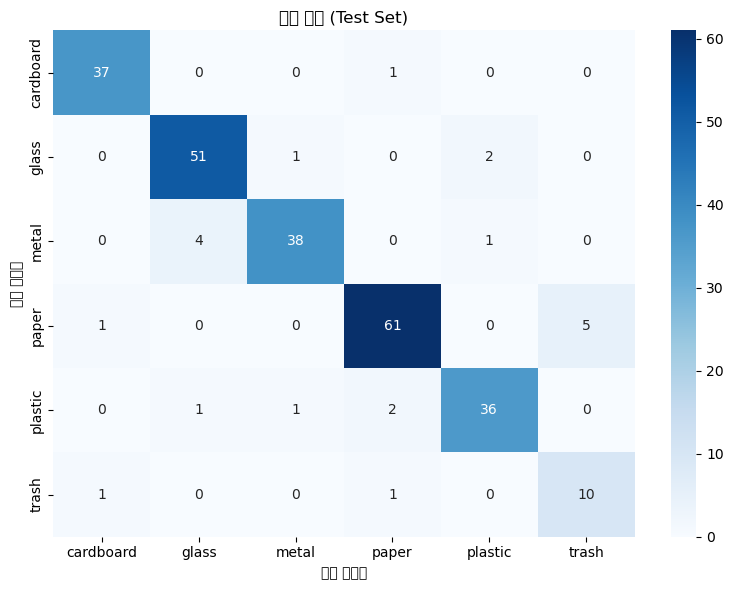

In [107]:
# 실행
start = time.time()

print("\n학습 시작")
train_model()

print(f"\n총 학습 시간: {time.time() - start:.2f}초")

print("\n모델 평가 시작")
evaluate_model()

C:\Users\KDP38\AppData\Local\Temp\ipykernel_17020\1757059119.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


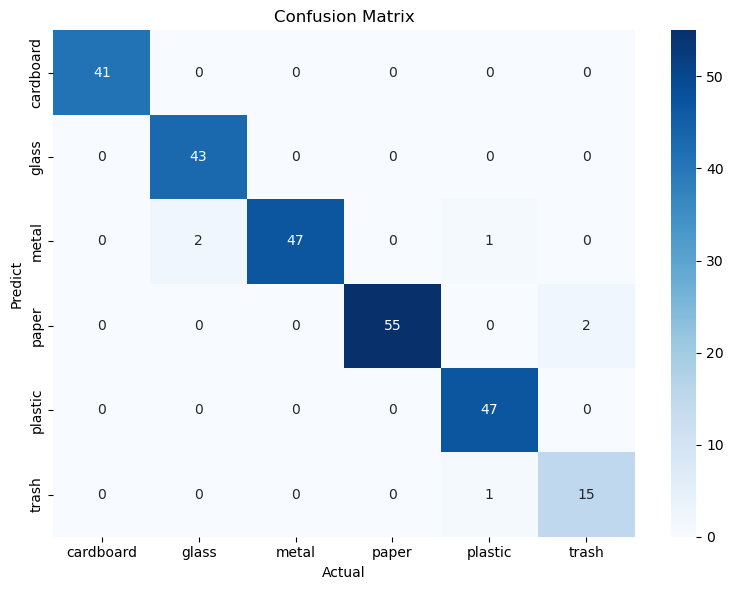

In [8]:
# 1. 모델과 데이터 로딩
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# 2. 전체 예측 수행
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# 3. 혼동 행렬 계산
cm = confusion_matrix(all_labels, all_preds)

# 4. 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predict")
plt.tight_layout()
plt.show()

In [34]:
from PIL import Image
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

# 클래스 이름 정의
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# 전처리 정의
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 예측 함수
def predict_image_full(image_path, model, device):
    """
    이미지 한 장을 넣으면 6개 클래스 중 예측 결과 출력 + 이미지 시각화
    """
    # 이미지 불러오기
    image = Image.open(image_path).convert('RGB')
    input_tensor = inference_transform(image).unsqueeze(0).to(device)

    # 예측
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1)[0]
        pred_idx = torch.argmax(prob).item()
        pred_label = class_names[pred_idx]
        confidence = prob[pred_idx].item()

    # 결과 출력
    print(f"예측 결과: {pred_label.upper()} (신뢰도: {confidence:.2%})")

    # 이미지 시각화
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {pred_label} ({confidence:.2%})")
    plt.show()

    return pred_label


예측 결과: CARDBOARD (신뢰도: 99.44%)


C:\Users\KDP38\AppData\Local\Temp\ipykernel_24240\216803028.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_locatio

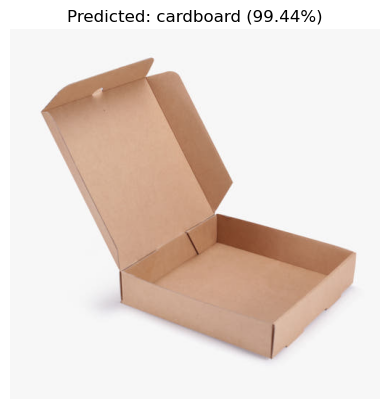

'cardboard'

In [14]:
# 모델 로드
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model = model.to(device)

# 예측할 이미지 경로
image_path = "./test/paper.jpg"

# 예측 실행 + 이미지 출력
predict_image_full(image_path, model, device)


C:\Users\KDP38\AppData\Local\Temp\ipykernel_24240\4032417180.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_locati

예측 결과: PLASTIC (신뢰도: 98.37%)


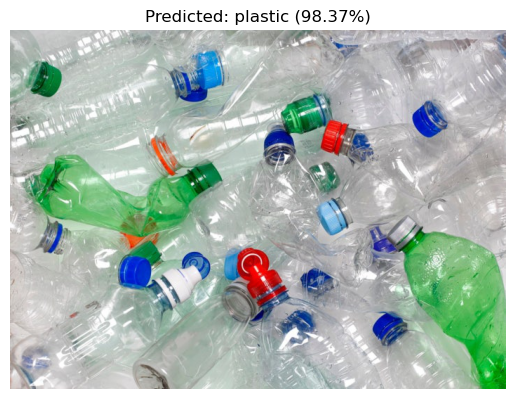

'plastic'

In [15]:
# 모델 로드
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model = model.to(device)

# 예측할 이미지 경로
image_path = "./test/plastic.jpg"

# 예측 실행 + 이미지 출력
predict_image_full(image_path, model, device)

예측 결과: METAL (신뢰도: 96.10%)


C:\Users\KDP38\AppData\Local\Temp\ipykernel_24240\2165948611.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_locati

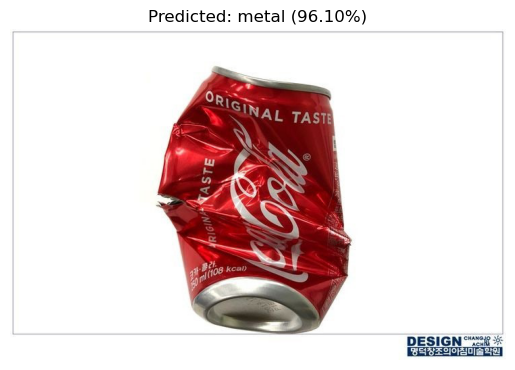

'metal'

In [18]:
# 모델 로드
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model = model.to(device)

# 예측할 이미지 경로
image_path = "./test/can.jpg"

# 예측 실행 + 이미지 출력
predict_image_full(image_path, model, device)

C:\Users\KDP38\AppData\Local\Temp\ipykernel_10524\758341715.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_locatio

예측 결과: TRASH (신뢰도: 77.81%)


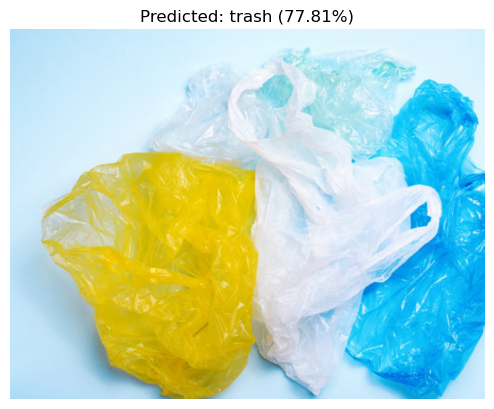

'trash'

In [35]:
# 모델 로드
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model = model.to(device)

# 예측할 이미지 경로
image_path = "./test/vinyl.jpg"

# 예측 실행 + 이미지 출력
predict_image_full(image_path, model, device)